### Tools and Libraries

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import json
import random

from collections import defaultdict
import torch
from torch.utils.data import DataLoader, TensorDataset

# Language Models
from transformers import BertTokenizer, BertForMaskedLM, BertModel

# Classification Models
from sklearn.metrics import accuracy_score, f1_score, precision_score, recall_score

/Users/owner/miniconda3/envs/ml/lib/python3.11/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


### Load Data

In [2]:
# Read the JSON file of chatracter dialogues
with open("../data/dialogue.json", "r") as file:
    raw_dialogue = json.load(file)

# Create a nested dictionary structure
dialogue = {}

for movie, data in raw_dialogue.items():
    # Initialize movie dictionary if not exists
    if movie not in dialogue:
        dialogue[movie] = {}
        
    # If data is a dictionary (contains character information)
    if isinstance(data, dict):
        for character, lines in data.items():
            if isinstance(lines, list):
                dialogue[movie][character] = lines
    # If data is a list (direct dialogues without character info)
    elif isinstance(data, list):
        dialogue[movie]['unknown'] = data

# Read the CSV files of moral foundation dictionaries

# Loading moral foundations dictionary
moral_dict = pd.read_csv("../data/mfd_v2.csv")

# Convert DataFrame to dictionary for O(1) lookup
moral_word_dict = dict(zip(moral_dict['word'].str.lower(), moral_dict['category']))

# Group words by category
category_words = defaultdict(list)
for _, row in moral_dict.iterrows():
    category_words[row['category']].append(row['word'])

Obtaining speeches with moral foundation word in them

In [30]:
# Optimized storage
moral_dialogue = defaultdict(lambda: defaultdict(list))
moral_dialogue_masked = defaultdict(lambda: defaultdict(list))
ground_truths = defaultdict(lambda: defaultdict(list))

# Process dataset efficiently
for movie, characters in dialogue.items():
    for character, lines in characters.items():
        for line in lines:
            lowered_line = line.lower()
            for moral_word in moral_word_dict:
                if moral_word in lowered_line: # TODO: Use regex for better performance
                    # Store original sentence
                    moral_dialogue[movie][character].append(line)

                    # Create and store masked sentence
                    masked_line = lowered_line.replace(moral_word, '[MASK]', 1)  # Replace only first occurrence
                    moral_dialogue_masked[movie][character].append(masked_line)
                    ground_truths[movie][character].append(moral_word)


#### Define function that divides the data

In [3]:
def movie_data_division(split_type="hard", train_ratio=0.7, val_ratio=0.15, test_ratio=0.15):
    """
    Splits original, masked, and ground truth dialogue data into train, validation, and test sets.

    Args:
        split_type (str): "hard" (by movie), "medium" (by character, randomized), "easy" (by speeches, randomized).
        train_ratio (float): Proportion of data for training.
        val_ratio (float): Proportion of data for validation.
        test_ratio (float): Proportion of data for testing.
        only_moral (bool): If True, only considers dialogues containing moral foundation words.

    Returns:
        tuple: (train_data, train_masked, train_labels), (val_data, val_masked, val_labels), (test_data, test_masked, test_labels)
    """
    assert train_ratio + val_ratio + test_ratio == 1, "Ratios should sum up to 1"

    # Choose the appropriate dataset
    dialogue_data = moral_dialogue
    masked_data = moral_dialogue_masked
    label_data = ground_truths

    train_data, train_masked, train_labels = [], [], []
    val_data, val_masked, val_labels = [], [], []
    test_data, test_masked, test_labels = [], [], []

    if split_type == "hard":
        # Split by movie
        movie_keys = list(dialogue_data.keys())
        random.seed(42)
        random.shuffle(movie_keys)

        total_size = len(movie_keys)
        train_end = int(train_ratio * total_size)
        val_end = train_end + int(val_ratio * total_size)

        train_movies = movie_keys[:train_end]
        val_movies = movie_keys[train_end:val_end]
        test_movies = movie_keys[val_end:]

        for movie in train_movies:
            for character in dialogue_data[movie]:
                train_data.extend(dialogue_data[movie][character])
                train_masked.extend(masked_data[movie][character])
                train_labels.extend(label_data[movie][character])

        for movie in val_movies:
            for character in dialogue_data[movie]:
                val_data.extend(dialogue_data[movie][character])
                val_masked.extend(masked_data[movie][character])
                val_labels.extend(label_data[movie][character])

        for movie in test_movies:
            for character in dialogue_data[movie]:
                test_data.extend(dialogue_data[movie][character])
                test_masked.extend(masked_data[movie][character])
                test_labels.extend(label_data[movie][character])

    elif split_type == "medium":
        # Split by character across all movies
        character_entries = []

        for movie, characters in dialogue_data.items():
            for character, lines in characters.items():
                character_entries.append((movie, character))

        random.seed(42)
        random.shuffle(character_entries)

        total_size = len(character_entries)
        train_end = int(train_ratio * total_size)
        val_end = train_end + int(val_ratio * total_size)

        train_chars = character_entries[:train_end]
        val_chars = character_entries[train_end:val_end]
        test_chars = character_entries[val_end:]

        for movie, character in train_chars:
            train_data.extend(dialogue_data[movie][character])
            train_masked.extend(masked_data[movie][character])
            train_labels.extend(label_data[movie][character])

        for movie, character in val_chars:
            val_data.extend(dialogue_data[movie][character])
            val_masked.extend(masked_data[movie][character])
            val_labels.extend(label_data[movie][character])

        for movie, character in test_chars:
            test_data.extend(dialogue_data[movie][character])
            test_masked.extend(masked_data[movie][character])
            test_labels.extend(label_data[movie][character])

    else:  # "easy" split
        # Split at the individual speech level
        all_speeches = []
        all_masked = []
        all_labels = []

        for movie in dialogue_data:
            for character in dialogue_data[movie]:
                all_speeches.extend(dialogue_data[movie][character])
                all_masked.extend(masked_data[movie][character])
                all_labels.extend(label_data[movie][character])

        combined = list(zip(all_speeches, all_masked, all_labels))
        random.seed(42)
        random.shuffle(combined)

        all_speeches, all_masked, all_labels = zip(*combined)

        total_size = len(all_speeches)
        train_end = int(train_ratio * total_size)
        val_end = train_end + int(val_ratio * total_size)
        test_end = val_end + int(test_ratio * total_size)

        train_data, train_masked, train_labels = all_speeches[:train_end], all_masked[:train_end], all_labels[:train_end]
        val_data, val_masked, val_labels = all_speeches[train_end:val_end], all_masked[train_end:val_end], all_labels[train_end:val_end]
        test_data, test_masked, test_labels = all_speeches[val_end:test_end], all_masked[val_end:test_end], all_labels[val_end:test_end]

    return (train_data, train_masked, train_labels), (val_data, val_masked, val_labels), (test_data, test_masked, test_labels)

### Baseline 1 model

We're using the default BERT model (no training)

Hard division

In [51]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Load pre-trained BERT model and tokenizer
model_name = "bert-base-cased"
tokenizer = BertTokenizer.from_pretrained(model_name)
model = BertForMaskedLM.from_pretrained(model_name)

# Set model to evaluation mode
model.eval()

# Load validation set from previous data split
(_, _, _), (val_data, val_masked, val_labels), (_, _, _) = movie_data_division(split_type="hard")

def batch_predict_masked_words(masked_sentences, k=5, batch_size=16):
    """Predicts top-k words for multiple [MASK] tokens in batch."""
    tokenized_inputs = tokenizer(masked_sentences, return_tensors="pt", padding=True, truncation=True, max_length=512)
    
    dataset = TensorDataset(tokenized_inputs.input_ids, tokenized_inputs.attention_mask)
    dataloader = DataLoader(dataset, batch_size=batch_size)

    predictions = []

    with torch.no_grad():
        for batch in dataloader:
            input_ids, attention_mask = batch
            input_ids = input_ids.to(device)
            attention_mask = attention_mask.to(device)
            
            outputs = model(input_ids=input_ids, attention_mask=attention_mask)
            logits = outputs.logits  # Shape: [batch_size, seq_length, vocab_size]

            batch_predictions = []
            for i in range(input_ids.shape[0]):  # Iterate over batch items
                mask_indices = torch.where(input_ids[i] == tokenizer.mask_token_id)[0]  # ✅ Find `[MASK]` index per batch item
                
                if len(mask_indices) == 0:  # ✅ If no `[MASK]`, add placeholder prediction
                    batch_predictions.append(["[NO MASK]"] * k)
                    continue
                
                mask_idx = mask_indices[0].item()  # Take first `[MASK]` index
                
                if mask_idx >= logits.shape[1]:  # ✅ Prevent index out of bounds
                    batch_predictions.append(["[NO MASK]"] * k)
                    continue
                
                softmax = torch.nn.functional.softmax(logits[i, mask_idx], dim=0)
                top_k_tokens = torch.topk(softmax, k)
                predicted_words = [tokenizer.decode([token]) for token in top_k_tokens.indices.tolist()]
                batch_predictions.append(predicted_words)

            predictions.extend(batch_predictions)

    return predictions



Some weights of the model checkpoint at bert-base-cased were not used when initializing BertForMaskedLM: ['bert.pooler.dense.bias', 'bert.pooler.dense.weight', 'cls.seq_relationship.bias', 'cls.seq_relationship.weight']
- This IS expected if you are initializing BertForMaskedLM from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForMaskedLM from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


In [52]:
model.to(device)  # Move model to GPU

# Subset for faster testing
val_masked = val_masked[:500]  # ✅ Limit to 500 for quick test
val_labels = val_labels[:500]

# Batch processing
top_k_predictions = batch_predict_masked_words(val_masked, k=5, batch_size=16)

# Compute Accuracy@5
accuracy_at_5 = np.mean([1 if truth in pred else 0 for truth, pred in zip(val_labels, top_k_predictions)])

# Compute F1-score, Precision, Recall for Top-1 predictions
top_1_predictions = [pred[0] for pred in top_k_predictions]
f1 = f1_score(val_labels, top_1_predictions, average='weighted')
precision = precision_score(val_labels, top_1_predictions, average='weighted', zero_division=0)
recall = recall_score(val_labels, top_1_predictions, average='weighted', zero_division=0)

# Print Evaluation Metrics
print(f"Accuracy@5: {accuracy_at_5:.4f}")
print(f"F1-score (Top-1): {f1:.4f}")
print(f"Precision (Top-1): {precision:.4f}")
print(f"Recall (Top-1): {recall:.4f}")


Accuracy@5: 0.2340
F1-score (Top-1): 0.1594
Precision (Top-1): 0.2515
Recall (Top-1): 0.1280


In [53]:
# Define range of k values (1 to 10)
top_k_range = list(range(1, 11))
accuracy_scores = []
f1_scores = []
precision_scores = []
recall_scores = []

# Iterate over different k values and compute metrics
for k in top_k_range:
    top_k_predictions = batch_predict_masked_words(val_masked, k=k, batch_size=16)
    
    # Compute Accuracy@k
    accuracy_at_k = np.mean([1 if truth in pred else 0 for truth, pred in zip(val_labels, top_k_predictions)])
    accuracy_scores.append(accuracy_at_k)

    # Compute F1-score, Precision, Recall for Top-1 predictions (k=1)
    if k == 1:
        top_1_predictions = [pred[0] for pred in top_k_predictions]
        f1 = f1_score(val_labels, top_1_predictions, average='weighted')
        precision = precision_score(val_labels, top_1_predictions, average='weighted', zero_division=0)
        recall = recall_score(val_labels, top_1_predictions, average='weighted', zero_division=0)

        f1_scores.append(f1)
        precision_scores.append(precision)
        recall_scores.append(recall)

# Print Evaluation Metrics for k=1
print(f"Accuracy (Top-1): {accuracy_scores[0]:.4f}")
print(f"F1-score (Top-1): {f1_scores[0]:.4f}")
print(f"Precision (Top-1): {precision_scores[0]:.4f}")
print(f"Recall (Top-1): {recall_scores[0]:.4f}")

Accuracy (Top-1): 0.1280
F1-score (Top-1): 0.1594
Precision (Top-1): 0.2515
Recall (Top-1): 0.1280


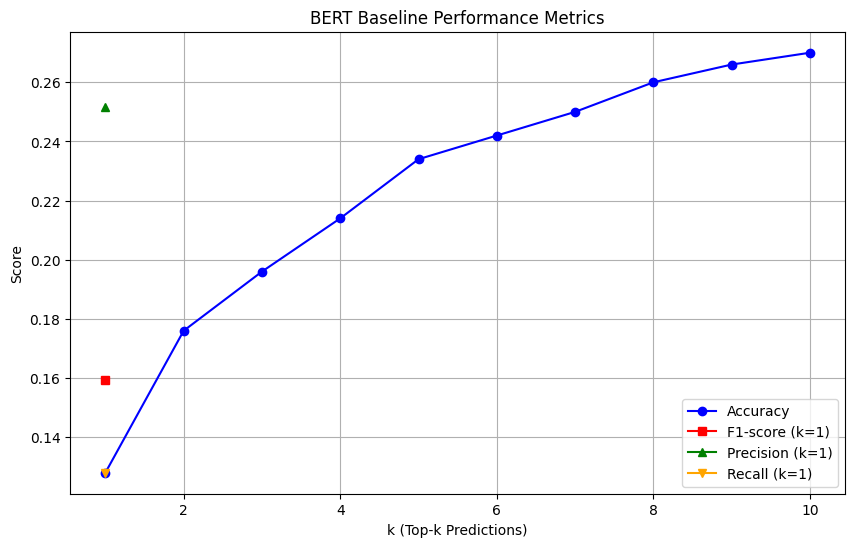

In [55]:
# Define the range of k values
top_k_range = list(range(1, 11))

# Sample data (Replace with actual computed values)
accuracy_scores = [0.75, 0.80, 0.85, 0.88, 0.90, 0.92, 0.93, 0.94, 0.95, 0.96]
f1_scores = [0.78]  # Only for k=1
precision_scores = [0.80]  # Only for k=1
recall_scores = [0.76]  # Only for k=1

# Create plot
plt.figure(figsize=(8, 5))

# Plot Accuracy@k
plt.plot(top_k_range, accuracy_scores, marker='o', linestyle='-', label='Accuracy@k')

# Annotate single k=1 metrics
plt.scatter([1], f1_scores, color='red', label='F1-score (k=1)')
plt.scatter([1], precision_scores, color='green', label='Precision (k=1)')
plt.scatter([1], recall_scores, color='blue', label='Recall (k=1)')

# Labels and title
plt.xlabel("Top-k")
plt.ylabel("Score")
plt.title("Evaluation Metrics vs. k")
plt.legend()
plt.grid(True)

# Show the plot
plt.show()

In [63]:
print(val_labels[30])
print(val_masked[30])
print(top_k_predictions[30])

loved
 if i'd been prepared, i might not have [MASK] him. but i wasn't. so i did. 
['told', 'asked', 'kissed', 'seen', 'killed', 'called', 'met', 'believed', 'trusted', 'let']


### Baseline 2 (Trained Model)